<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/single_subject/SingleSubjSVM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis and Visualization of Single Subject SVM
- This notebook will summarize statistics for Single Subject SVM
> Notebook outline
  1. Load data for Single Subject SVM
  2. Look at varying summary statistics and create tables
  3. Visualize summary statistics with boxplots
  4. Perform T-tests.
  5. Visualize highest and lowest performers for Single Subject SVM


In [51]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [52]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [53]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/single_subject
!ls

Cloning into 'teambrainiac'...
remote: Enumerating objects: 2395, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 2395 (delta 162), reused 238 (delta 140), pack-reused 2125
Receiving objects: 100% (2395/2395), 159.37 MiB | 12.06 MiB/s, done.
Resolving deltas: 100% (1553/1553), done.
/content/teambrainiac/source/single_subject/teambrainiac/source/single_subject
access_data.py					single_subject.py
brain_viz_single_subj.py			SingleSubjectSVM.ipynb
BuildSingleSubjectSVM_Models.ipynb		SingleSubjectSVM_Norm_CV.ipynb
data						SingleSubjSVM_Analysis.ipynb
DataExplorationNotebook_SingleSubjectSVM.ipynb	VisualizationPlayground.ipynb
__init__.py					VisualizationsNotebook.ipynb
process.py


In [54]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


In [55]:
# Import libraries
!pip install boto3 nilearn nibabel 
!pip install -U kaleido
#to load data
import pickle
#common packages we need
import numpy as np
import pandas as pd
#for brain imaging
import nibabel as nib
from nilearn import plotting, image
#for making graphs
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
from nilearn.image import threshold_img
#sklearn packages needed
from sklearn.metrics import accuracy_score,confusion_matrix,auc,roc_auc_score,precision_recall_curve,precision_score,recall_score,roc_curve
from sklearn.svm import SVC
#import code for processing and visualizing data
from single_subject import *
from access_data import *
from brain_viz_single_subj import *
##import statistical packages
from scipy import stats

####Grab Common Variables

In [56]:
#get common variables we need across multiple cells
data_path_dict = get_data_dict() #get data path dict which has our aws paths/subject ids list in it
subj_ids, _ = get_subj_information(data_path_dict) #grab subject ids
_ , y_test,_= get_labels(data_path_dict) #grab y_test since it is the same for all runs
##get brain images for visualization
affine_image,t1_image,mni_image = get_brain_templates()

####Get Mask List of Our Masks

In [57]:
##setting mask list
#masks we want to grab data on, needs to be nested list for cell to run
#indices of the masks we want 0 = whole brain mask and masks minus ROIs, 1 = ROIs
mask_indices = [0,1]
mask_list = []
for ind in mask_indices:
  mask_dict = get_mask_data(data_path_dict,ind)  
  masks = list(mask_dict.keys())[3:]
  mask_list.append(masks)
# Example of building your own
# mask_dict = get_mask_data(data_path_dict,0)
# mask_list = [['mask']]
# mask_list_small = [['mask'],mask_list[1]]
# mask_list_small

####Set Path List

In [58]:
#set data paths to our models
data_paths = [] #initialize list
#iterate over mask indices
for mask_ind in mask_indices:
  #iterate over masks
  for mask in mask_list[mask_ind]:
    data_paths.append(f'/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/models/{mask}_tr_1_2_subject_models.pkl') #append model path

##Get Subject Level Data and Get Metrics
>1. Create metrics dataframe of subject accuracy scores, sensitivity, specificity, precision and auc
>2. Create Summary Metrics for these tables on all mask types
>3. Create Boxplots to visualize the spread of all subjects

Note: Sensitivity is the same as recall, so only calculated this metric. Specificity is defined as tn/(tn+fp). Since we are interested in how well the negative class performs, this is a metric we can use to access that. In the fMRI literature they refer to recall as sensitivity and are very interested in specificity.

####Get data and runs metrics we want to capture

In [ ]:
#this cell grabs all subject data
metrics_list = [] #initialize empty list
inc_trials = np.where(y_test==1) #get indices of increase trials
dec_trials = np.where(y_test==0) #get indices of decrease trials
#iterate of data paths
for data_path in data_paths: 
  data = open_pickle(data_path) #open data file
  mask = list(data.keys())[0] #get mask
  subj_data = data[mask] #grab all subjects data
  for subj_id in subj_ids:
    subj_predicts = subj_data[subj_id]['predicts'] #get individual subject predictions
    #set group type
    if subj_id[0] == '1': #if subj id = 1 then adolescent, else young adult
      group = 'Adolescent'
    else:
      group = 'Young Adult'
    #iterate over runs
    for run in list(subj_predicts.keys()):
      subjs_acc_list = [mask,group,subj_id] #initialize subject accuracy list
      subjs_acc_list.append(run) #append run name
      subjs_acc_list.append(np.round_(accuracy_score(y_test,subj_predicts[run]['predicts']),2)) #get accuracy score
      subjs_acc_list.append(np.round_(accuracy_score(y_test[inc_trials],subj_predicts[run]['predicts'][inc_trials]),2)) #get sensitivity (same as recall tp/(tp+fn))
      subjs_acc_list.append(np.round_(accuracy_score(y_test[dec_trials],subj_predicts[run]['predicts'][dec_trials]),2)) #get specificity (tn/(tn+fp))
      subjs_acc_list.append(np.round_(precision_score(y_test,subj_predicts[run]['predicts']),2)) #get precision scores (tp/(tp+fp))
      subjs_acc_list.append(np.round_(roc_auc_score(y_test,subj_predicts[run]['proba'][:,1]),2)) #get auc score for positive class
      print(subjs_acc_list) #print
      metrics_list.append(subjs_acc_list) #append to list for further analysis
  #create individual mask df
  mask_df = pd.DataFrame(metrics_list,columns=['Mask Type','Group','Subject','Run','Accuracy','Sensitivity','Specificity','Precision','AUC'])
  #save file
  mask_df.to_csv(f'/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/metrics_{mask}_tr_2_te3_4.csv')
#create dataframe from list
metrics_df = pd.DataFrame(metrics_list,columns=['Mask Type','Group','Subject','Run','Accuracy','Sensitivity','Specificity','Precision','AUC'])
#savefile
metrics_df.to_csv('/content/drive/My Drive/data/singlesubjectmodels/metrics_allmask_tr_2_te3_4.csv')

####Get mean metrics across runs and create tables

In [67]:
#summary table by run on all subjects
#create mean metrics
all_subjects_by_runs = metrics_df.groupby(['Mask Type','Run']).mean().round(3)
all_subjects_by_runs.reset_index(inplace=True) #reset index
#parse out by runs to separate tables
all_subjects_run_3 = all_subjects_by_runs[all_subjects_by_runs['Run']=='run_03']
all_subjects_run_3 = all_subjects_run_3.reindex([6,8,10,12,14,0,2,4,16]) #change order to display
all_subjects_run_4 = all_subjects_by_runs[all_subjects_by_runs['Run']=='run_04'] 
all_subjects_run_4 = all_subjects_run_4.reindex([7,9,11,13,15,1,3,5,17]) #change order to display
#save file if wanted
#all_subjects_by_runs.to_csv('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/summary_statistics/summary_stats_all_subjects_by_runs_tr_2_te3_4.csv')
#create table and export for run 3
data=[go.Table(
    header=dict(values=list(all_subjects_by_runs.columns),
                fill_color='#96c6e2',
                align='center'),
    cells=dict(values=[all_subjects_run_3['Mask Type'],all_subjects_run_3.Run,all_subjects_run_3.Accuracy, all_subjects_run_3.Sensitivity, 
                       all_subjects_run_3.Specificity, all_subjects_run_3.Precision,
                       all_subjects_run_3.AUC],
               fill_color='#eaeaf2',
               align='center'))
]
layout = go.Layout(
    height=650,
    width = 870,
    title_text="Mean Metrics for Single Subject SVM for Run 3 Feedback Run",
    title_x=0.5,
    title_y=1,
    margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=15, #top margin
        )
    )
fig = go.Figure(data=data, layout=layout)
#optional save data locally
fig.write_image('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/metrics_data/metrics_tables/run_03.png')
fig.show()

In [65]:
#create table and export for run 04
data=[go.Table(
    #set header information
    header=dict(values=list(all_subjects_by_runs.columns),
                fill_color='#96c6e2',
                align='center'),
    #set table cell information
    cells=dict(values=[all_subjects_run_4['Mask Type'],all_subjects_run_4.Run,all_subjects_run_4.Accuracy, all_subjects_run_4.Sensitivity, 
                       all_subjects_run_4.Specificity, all_subjects_run_4.Precision,
                       all_subjects_run_4.AUC],
               fill_color='#eaeaf2',
               align='center'))
]
#specify layout
layout = go.Layout(
    height=650,
    width = 870,
    title_text="Mean Metrics for Single Subject SVM for Run 4 No Feedback Run",
    title_x=0.5,
    title_y=1,
    margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=15, #top margin
        )
    )
fig = go.Figure(data=data, layout=layout) #set figure with desired data and layout
#optional save data locally
fig.write_image('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/metrics_data/metrics_tables/run_04.png')
fig.show()

####Create box plot visualization

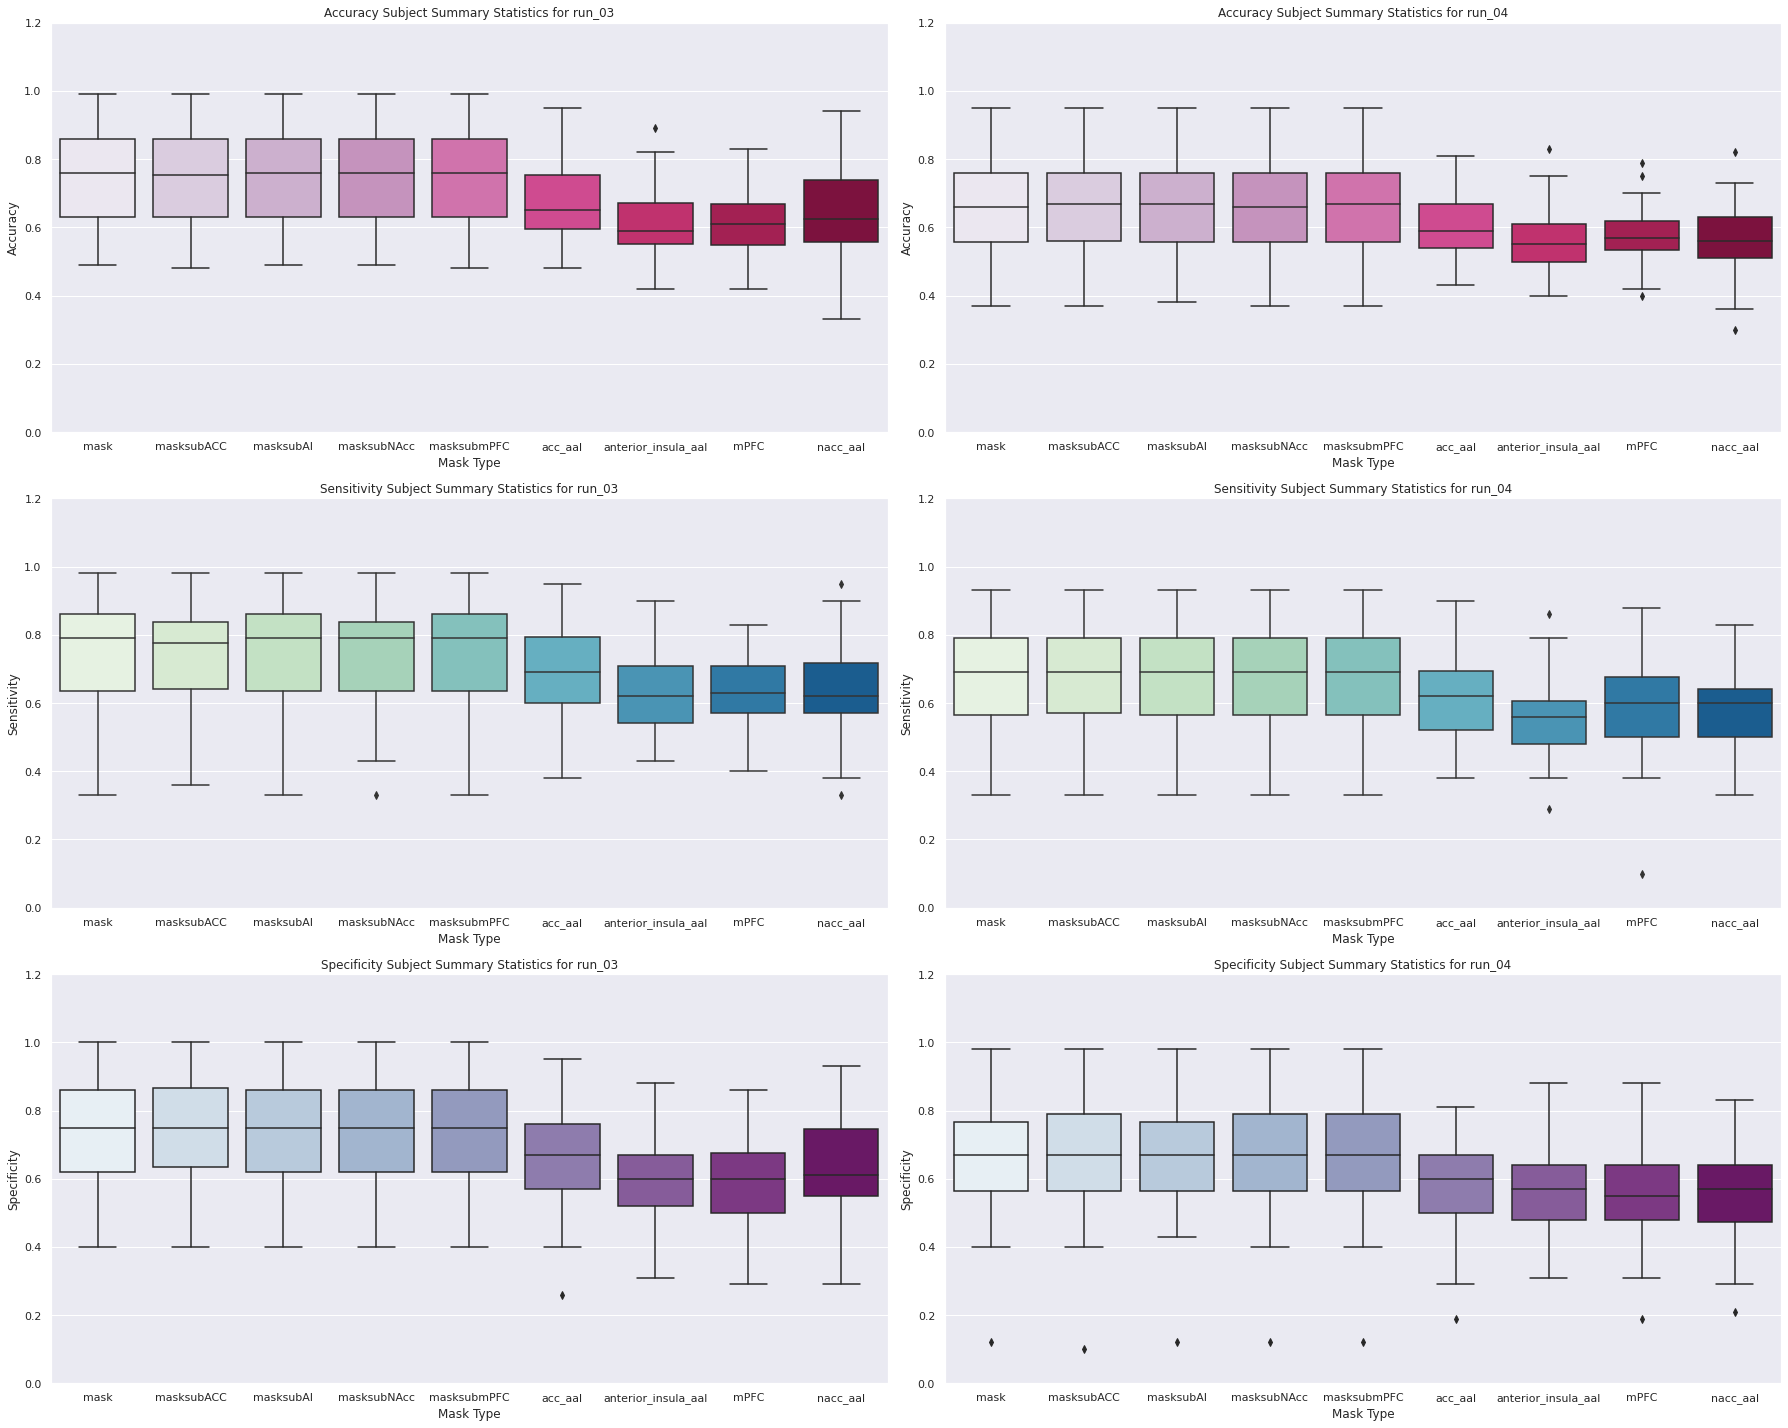

In [73]:
##create box plots accross all subjects by run
fig,axes=plt.subplots(3,2,figsize=(25,20)) #get figure size
plt.style.use('seaborn-darkgrid') #set background style
sns.set(font_scale = 1)#set font
column = 0 #initialize column count
row = 0 #initialize row count
runs_test = ['run_03','run_04'] #runs we are testing the model on
metrics = [('Accuracy','PuRd'),('Sensitivity','GnBu'),('Specificity','BuPu')] #list of tuples specifying metrics we want to visualize along with their color choice
#iterate over metrics
for metric,color in metrics:
  #iterate over runs
  for run in runs_test:
    df = metrics_df[metrics_df['Run']==run] #create run df
    sns.set(font_scale = 1) #set font size
    sns.boxplot(x='Mask Type',y=metric,data=df, ax=axes[row,column],palette=color) #create box plot
    axes[row,column].set_title(f'{metric} Subject Summary Statistics for {run}') #set title
    axes[row,column].set_ylim(0,1.2) #normalize y axis across graphs
    column+=1 #increase column count
  column=0 #re-initialize to zero
  row +=1 #increase row count
fig.tight_layout() #tight layout so box plots don't overlap
#optional save figure locally
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/boxplot_tr_2runs3_4_separate.png',dpi=200)

In [74]:
from scipy import stats
# metrics_df.groupby(['Mask Type','Group']).agg({'Accuracy': ['mean','std']})
# ttest_df = pd.DataFrame(columns=['Mask_Type','Mask_Compare','Group','Run','T_Test','P_value'])

##Visualize Different Model Metrics for High and Low Performing Models
####Get data and metrics

In [75]:
#get top performers and bottom performers data for visualization
performance_list=['Top Performers','Bottom Performers'] #create list to indicate top and bottom performers
#load data file (looking at whole brain mask only)
performance_dict = {} #initialize performance
#iterate over data paths
#could also change to itereate over all data paths for all subjects
data = open_pickle(f'/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/models/mask_tr_1_2_subject_models.pkl') #open data file
mask = list(data.keys())[0] #get mask
data_mask = data[mask] #subjects masked data
performance_dict[mask] = {} #initialize mask dictionary in performance
#iterate over performance type
for performance in performance_list:
  performance_dict[mask][performance] = {} #initialize performance dict in mask dict  
  if performance == 'Top Performers':
    top_n = metrics_df[(metrics_df['Mask Type']==mask) & (metrics_df['Run']=='run_03')].nlargest(1,'Accuracy') #get top performers based on accuracy (run 3 only)
    top_n_list = top_n.Subject.unique() #get top performers subject ids
    #iterate over subject ids
    for subj_id in top_n_list:
      #set group type
      if subj_id[0] == '1': #if subj id = 1 then adolescent, else young adult
        group = 'Adolescent'
      else:
        group = 'Young Adult'
      performance_dict[mask][performance][subj_id] = {} #initialize subject dictionary
      performance_dict[mask][performance][subj_id]['Group'] = group #set group type
      performance_dict[mask][performance][subj_id] = data_mask[subj_id] #store data     
  else:
    bottom_n = metrics_df[(metrics_df['Mask Type']==mask) & (metrics_df['Run']=='run_03')].nsmallest(1,'Accuracy') #get bottom performers based on accuracy (run 3 only)
    bottom_n_list = bottom_n.Subject.unique() #get bottom performers subject ids   
    for subj_id in bottom_n_list:
      performance_dict[mask][performance][subj_id] = {}
      performance_dict[mask][performance][subj_id]['Group'] = group
      performance_dict[mask][performance][subj_id] = data_mask[subj_id]
      


####Create Confusion Matrix

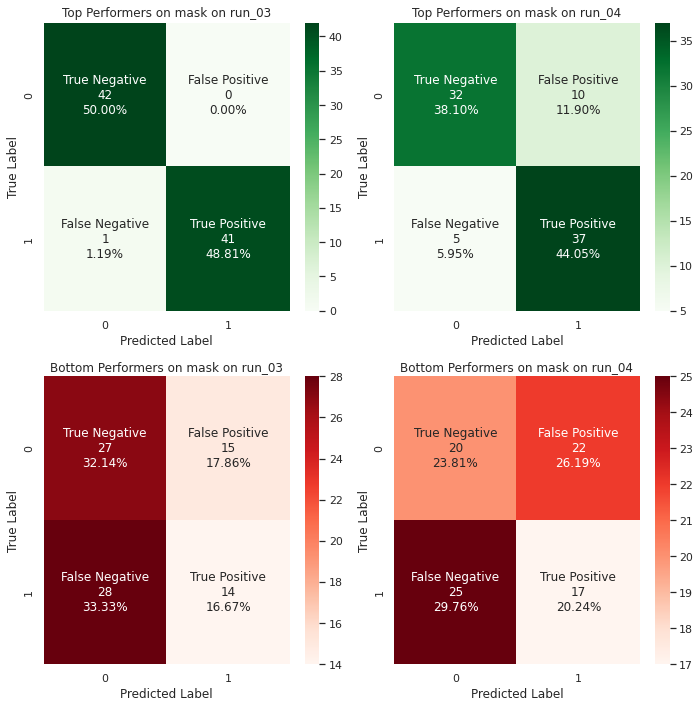

In [ ]:
##create confusion matrix across top and bottom performers
fig,axes=plt.subplots(2,2,figsize=(10,10)) #get figure size
plt.style.use('seaborn-darkgrid') #set figure display
sns.set(font_scale = 1) #set font size
column = 0 #initialize column count
row = 0 #initialize row count
runs_test = ['run_03','run_04'] #test runs to display
#loop over performers
for mask in list(performance_dict.keys()):
  mask_performance_dict = performance_dict[mask] #get data
  #loop over performance models
  for performance in list(mask_performance_dict.keys()):
    #set colors
    if performance == 'Top Performers':
      color = 'Greens'
    else:
      color = 'Reds'
    #get dictionary of mask data
    mask_pf_sub = mask_performance_dict[performance]
    #loop over subjects stored in performance dictionary
    for subj_id in list(mask_pf_sub.keys()):
      subj_predicts = mask_pf_sub[subj_id]['predicts'] #get subjects predict data
      #loop over runs stored
      for run in list(subj_predicts.keys()):
        predicts = subj_predicts[run]['predicts'] #get predicts
        cm = confusion_matrix(y_test,predicts) #create confusion matrix
        sns.set(font_scale = 1) #set font size
        group_names = ['True Negative','False Positive','False Negative','True Positive'] #get groups to display
        group_counts = ["{0:0.0f}".format(value) for value in #get group counts
                    cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                            cm.flatten()/np.sum(cm)] #get mean of classifications
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                  zip(group_names,group_counts,group_percentages)] #create labels for boxes in matrix
        labels = np.asarray(labels).reshape(2,2) #reshape
        sns.heatmap(cm, annot=labels, fmt='', cmap=color, ax=axes[row,column]) #create heatmap
        axes[row,column].set_xlabel("Predicted Label") #set x label
        axes[row,column].set_ylabel("True Label") #set y label
        axes[row,column].set_title(f'{performance} on {mask} on {run}') #set title
        column +=1 #update column count
    column = 0 # re-initialize column count
    row+=1 # update row count
 
fig.tight_layout() #tight layout so graphs don't overlap
#optional save to local output file
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/confusion_matrix_tr_2_runs3_4_by_run.png',dpi=200)

####Create ROC Curve

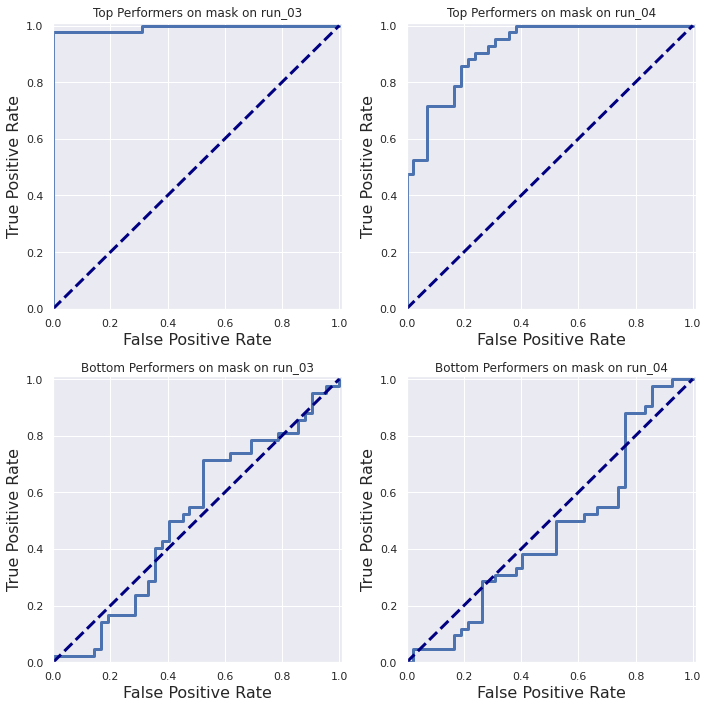

In [ ]:
##create roc curve
fig,axes=plt.subplots(2,2,figsize=(10,10)) #get figure size
plt.style.use('seaborn-darkgrid') #style to use
sns.set(font_scale = 1) #set font size
column = 0 #initialize column count
row = 0 #initialize row count
runs_test = ['run_03','run_04'] #runs we are testing on
#iterate over masks
for mask in list(performance_dict.keys()):
  mask_performance_dict = performance_dict[mask] #get mask data
  # iterate over performance type
  for performance in list(mask_performance_dict.keys()):
    mask_pf_sub = mask_performance_dict[performance] #get performance type data
    #iterate over subjects
    for subj_id in list(mask_pf_sub.keys()):
      subj_predicts = mask_pf_sub[subj_id]['predicts'] #get individual data
      #iterate over runs over runs
      for run in list(subj_predicts.keys()):
        proba_scores = subj_predicts[run]['proba'] #get probability scores
        fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_scores[:,1]) #get roc scores
        #plot the scores
        axes[row,column].plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
        #set axis limits
        axes[row,column].set_xlim([0.0, 1.01])
        axes[row,column].set_ylim([0.0, 1.01])
        #plot straight line
        axes[row,column].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        #set labels
        axes[row,column].set_xlabel('False Positive Rate', fontsize=16)
        axes[row,column].set_ylabel('True Positive Rate', fontsize=16)
        axes[row,column].set_title(f'{performance} on {mask} on {run}') #set title
        column +=1 #update column count
    column = 0 #re-initialize column count
    row+=1 #update row count
fig.tight_layout() #tight layout
#optional save locally
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/roc_tr_2_runs3_4_by_run.png',dpi=200)

####Create Decision Function Scores

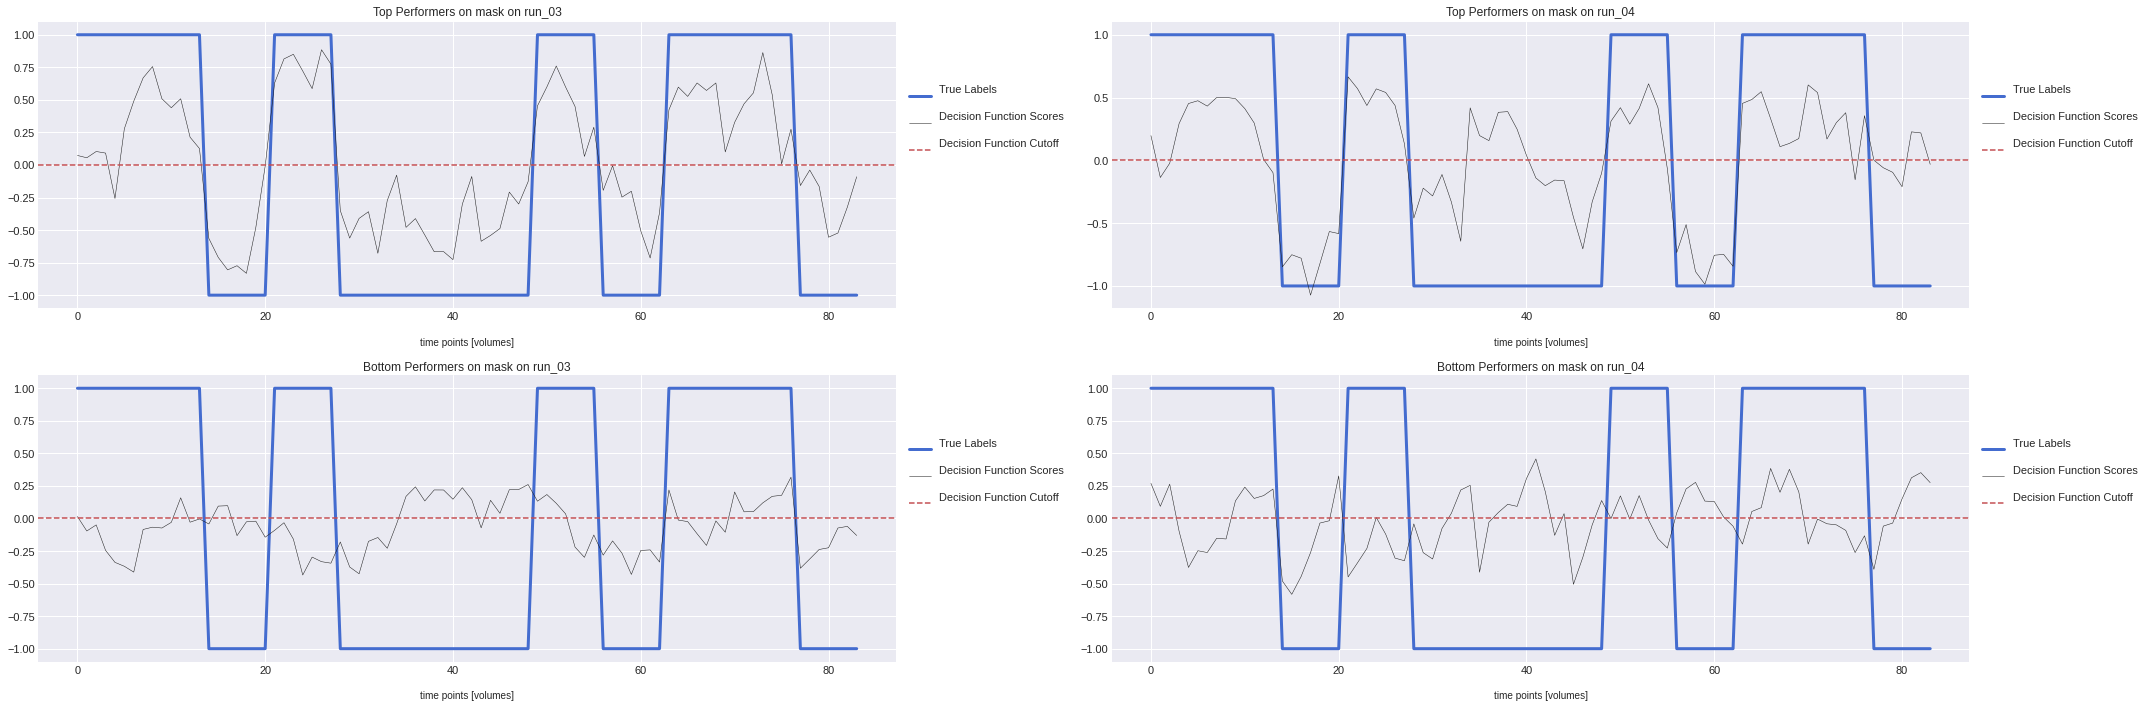

In [ ]:
##create precision recall curve
decision_function_labels = np.where(y_test==0,-1,1) #put scores in range of -1, 1 to match svm outputs
fig,axes=plt.subplots(4,1,figsize=(10,10)) #get figure size
plt.style.use('seaborn-darkgrid') #style to use
sns.set(font_scale = 1) #set font size
column = 0 #initialize column count
row = 0 #initialize row count
runs_test = ['run_03','run_04'] #runs we are testing on
#iterate over masks
for mask in list(performance_dict.keys()):
  mask_performance_dict = performance_dict[mask] #get mask data
  # iterate over performance type
  for performance in list(mask_performance_dict.keys()):
    mask_pf_sub = mask_performance_dict[performance] #get performance type data
    #iterate over subjects
    for subj_id in list(mask_pf_sub.keys()):
      subj_predicts = mask_pf_sub[subj_id]['predicts'] #get individual data
      #iterate over runs over runs
      for run in list(subj_predicts.keys()):
        decf_scores = subj_predicts[run]['decision_function'] #get decision function scores
        axes[row].plot(decision_function_labels, lw=3, c='#446CCF',label='True Labels\n') #plot decision function labels
        axes[row].plot(decf_scores,c='k',lw=0.5,linestyle='-',label='Decision Function Scores\n') #plot decision function scores
        axes[row].axhline(y=0,c='r',linestyle='--',label='Decision Function Cutoff\n') #plot decision function cutoff
        #x-axis
        axes[row].set_xlabel('\ntime points [volumes]',
                        fontsize=10
                        )
        ax[row,column].set_title(f'{performance} on {mask} on {run}')
        lgd = ax[row,column].legend(loc=(1.01, 0.5))
        row +=1 #update row count
    #column = 0 #re-initialize column count
    row+=1 #update row count
fig.tight_layout() #tight layout
#optional save locally
fig.tight_layout()
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/desf_tr_2_runs3_4_by_run.png',dpi=200)

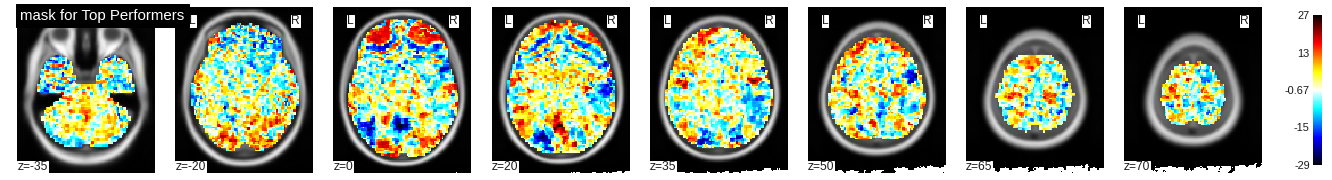

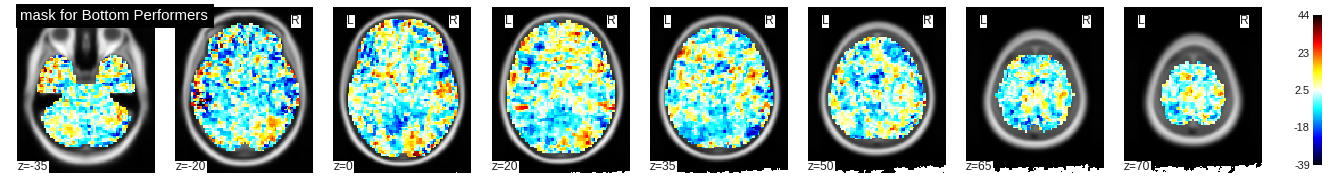

In [ ]:
performance_list=['Top Performers','Bottom Performers']
mask_dict = get_mask_data(data_path_dict,0)
_, ind = make_mask(mask_dict['mask'])
for mask in list(performance_dict.keys()):
  mask_performance_dict = performance_dict[mask]
  for performance in list(mask_performance_dict.keys()):
    mask_pf_sub = mask_performance_dict[performance]  
    for subj_id in list(mask_pf_sub.keys()):
      _,bmap3 = create_bmaps(mask_pf_sub[subj_id],ind,affine_image)
      plot_map(bmap3,'mask',performance,out_fname=None,threshold = 0, t_image = mni_image, display='z')

{'mask': {'Bottom Performers': {'10036_09800': {'X_train': array([[-1.6787387 , -1.4781371 ,  0.88037544, ...,  0.        ,
             0.48376146,  1.77587   ],
           [ 0.08586245,  0.36705926,  0.24809231, ...,  0.        ,
            -0.8709435 ,  1.0888948 ],
           [ 1.0420527 ,  1.1129586 ,  0.29362738, ...,  0.        ,
             0.47283313, -0.2819913 ],
           ...,
           [-0.96863574, -0.9568765 , -0.81275016, ...,  0.        ,
             1.3904041 , -0.5240468 ],
           [-0.40510234, -0.43285382, -0.5104657 , ...,  0.        ,
            -1.3135417 ,  1.182667  ],
           [-0.5806876 , -0.2618165 ,  0.6339566 , ...,  0.        ,
            -1.3190058 , -0.1882192 ]], dtype=float32),
    'model': SVC(C=5, gamma='auto', probability=True),
    'predicts': {'run_03': {'decision_function': array([ 0.01550656, -0.0962689 , -0.04936031, -0.2451636 , -0.33715965,
             -0.3672891 , -0.41201221, -0.08440371, -0.06686514, -0.07326195,
          